In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pneumoniamnist/pneumoniamnist.npz


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from skimage.metrics import structural_similarity as ssim
import seaborn as sns

2025-07-08 08:01:06.551154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751961666.767019      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751961666.830180      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data = np.load('/kaggle/input/pneumoniamnist/pneumoniamnist.npz')
x_train, y_train = data['train_images'], data['train_labels']
x_val, y_val = data['val_images'], data['val_labels']
x_test, y_test = data['test_images'], data['test_labels']

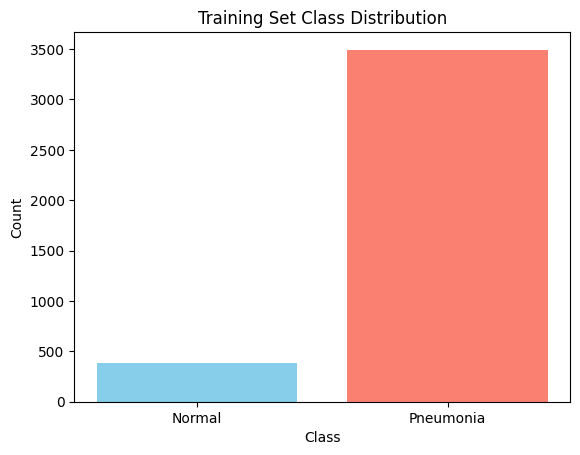

In [4]:
def plot_distribution(y, title):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(['Normal', 'Pneumonia'], counts, color=['skyblue', 'salmon'])
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

plot_distribution(y_train, "Training Set Class Distribution")

In [5]:
def preprocess_images(images):
    images = np.repeat(images[..., np.newaxis], 3, axis=-1)  # 3-channel
    images = tf.image.resize(images, (299, 299))              # resize
    return images.numpy() / 255.0

x_train = preprocess_images(x_train)
x_val = preprocess_images(x_val)
x_test = preprocess_images(x_test)

I0000 00:00:1751961681.288406      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751961681.289075      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
y_train_cat = to_categorical(y_train, 2)
y_val_cat = to_categorical(y_val, 2)
y_test_cat = to_categorical(y_test, 2)

In [7]:
from sklearn.utils import class_weight

In [8]:
if len(y_train.shape) > 1:
    y_train_flat = np.argmax(y_train, axis=1)
else:
    y_train_flat = y_train

In [9]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train_flat),
                                             y=y_train_flat)

class_weights = {i: weights[i] for i in range(len(weights))}
print("Computed class weights:", class_weights)

Computed class weights: {0: 1.0}


In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [11]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
history = model.fit(datagen.flow(x_train, y_train_cat, batch_size=32),
                    validation_data=(x_val, y_val_cat),
                    epochs=10,
                    class_weight=class_weights,
                    callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1751961709.522095      98 service.cc:148] XLA service 0x7b446005b160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751961709.522846      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751961709.522870      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751961711.425188      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/122 ━━━━━━━━━━━━━━━━━━━━ 49:42 25s/step - accuracy: 0.3750 - loss: 0.9351

I0000 00:00:1751961722.406209      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 ━━━━━━━━━━━━━━━━━━━━ 116s 752ms/step - accuracy: 0.8474 - loss: 0.4050 - val_accuracy: 0.8569 - val_loss: 0.3107
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 582ms/step - accuracy: 0.9290 - loss: 0.1803 - val_accuracy: 0.9084 - val_loss: 0.2273
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 573ms/step - accuracy: 0.9305 - loss: 0.1806 - val_accuracy: 0.9237 - val_loss: 0.2043
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 584ms/step - accuracy: 0.9249 - loss: 0.1718 - val_accuracy: 0.8989 - val_loss: 0.2267
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 582ms/step - accuracy: 0.9339 - loss: 0.1698 - val_accuracy: 0.9370 - val_loss: 0.1799
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 575ms/step - accuracy: 0.9486 - loss: 0.1465 - val_accuracy: 0.9237 - val_loss: 0.1864
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 573ms/step - accuracy: 0.9347 - loss: 0.1602 - val_accuracy: 0.9370 - val_loss: 0.1702
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 582ms/step - accuracy: 0.9298 - loss: 0.1539 - va

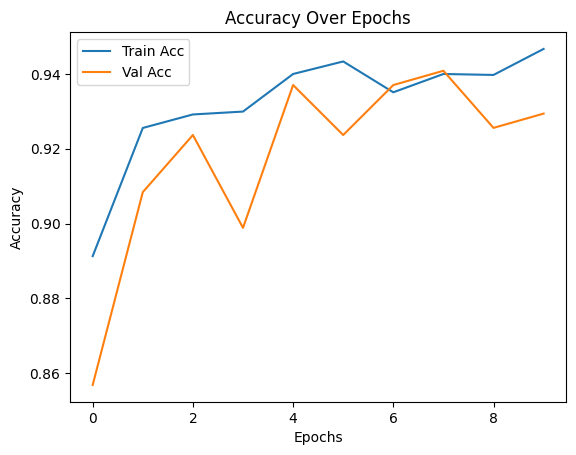

In [14]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [15]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 685ms/step


In [16]:
auc_score = roc_auc_score(y_true, y_pred_probs[:,1])
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9409


In [17]:
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.4f}")


F1 Score: 0.8918


In [18]:
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred)
print(f"Precision Score: {precision:.4f}")

Precision Score: 0.8315


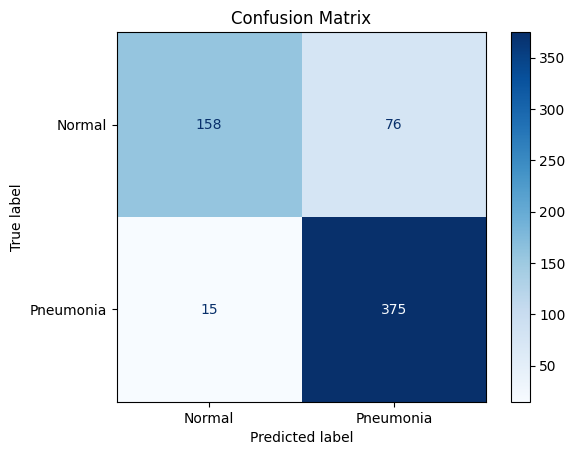

In [19]:
conf_mat = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

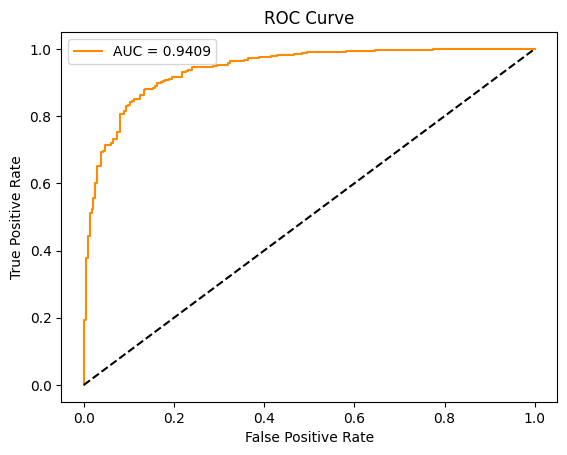

In [20]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [21]:
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      0.68      0.78       234
   Pneumonia       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



In [22]:
model.save("InceptionV3_Pneumonia_Final.h5")